# PPO (Proximal Policy Optimization) - Classic RL

## What is This?
This notebook demonstrates **PPO** - a reinforcement learning algorithm - applied to the **CartPole** game.

### The Task:
Balance a pole on a moving cart by moving left/right.

### PPO vs RLHF with PPO:

| Aspect | **This Notebook (PPO Only)** | **The Previous Notebook (RLHF with PPO)** |
|--------|------------------------------|--------------------------------------------|
| **What** | Playing CartPole game | Training language model |
| **Reward** | +1 per timestep pole is balanced | Quality score from reward model |
| **Goal** | Maximize game score | Generate human-preferred text |
| **Agent** | Neural network choosing actions | GPT-2 generating words |
| **Application** | Games, robotics | ChatGPT, assistants |

### Key Insight:
- **PPO** is the learning algorithm (works for any task)
- **RLHF** is using PPO specifically for language models with human feedback

---

## Step 1: Install Dependencies

In [ ]:
!pip install torch gymnasium numpy matplotlib -q
print("✓ Packages installed")

✓ Packages installed


## Step 2: Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Step 3: Define the PPO Agent

This neural network learns to play CartPole.

In [ ]:
class PPOAgent(nn.Module):
    """
    PPO Agent with Actor-Critic architecture.

    - Actor: Decides which action to take (policy)
    - Critic: Estimates how good the current state is (value function)
    """
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(PPOAgent, self).__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
        )

        # Actor head (policy)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )

        # Critic head (value function)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, state):
        """Forward pass through the network."""
        shared_out = self.shared(state)
        action_probs = F.softmax(self.actor(shared_out), dim=-1)
        state_value = self.critic(shared_out)
        return action_probs, state_value

    def act(self, state):
        """Choose an action based on the current state."""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs, _ = self.forward(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        return action.item(), action_log_prob.item()

    def evaluate(self, states, actions):
        """Evaluate actions taken in given states."""
        action_probs, state_values = self.forward(states)
        dist = Categorical(action_probs)
        action_log_probs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_log_probs, state_values, dist_entropy

print("✓ PPO Agent defined")

✓ PPO Agent defined


## Step 4: PPO Training Configuration

In [ ]:
# Environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]  # 4 (cart position, cart velocity, pole angle, pole velocity)
action_dim = env.action_space.n  # 2 (left, right)

# PPO Hyperparameters
config = {
    'max_episodes': 500,
    'max_timesteps': 500,
    'update_timestep': 2000,
    'learning_rate': 0.002,
    'gamma': 0.99,  # Discount factor
    'clip_epsilon': 0.2,  # PPO clipping parameter
    'ppo_epochs': 10,
    'entropy_coef': 0.01,  # Encourage exploration
}

print("Environment: CartPole-v1")
print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print("\nPPO Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Environment: CartPole-v1
State dimension: 4
Action dimension: 2

PPO Configuration:
  max_episodes: 500
  max_timesteps: 500
  update_timestep: 2000
  learning_rate: 0.002
  gamma: 0.99
  clip_epsilon: 0.2
  ppo_epochs: 10
  entropy_coef: 0.01


## Step 5: Initialize Agent

In [ ]:
# Create agent
agent = PPOAgent(state_dim, action_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=config['learning_rate'])

# Memory for storing experiences
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.log_probs.clear()
        self.rewards.clear()
        self.is_terminals.clear()

memory = Memory()

print("✓ Agent initialized")
print(f"Total parameters: {sum(p.numel() for p in agent.parameters())}")

✓ Agent initialized
Total parameters: 8835


## Step 6: PPO Update Function

This is the core PPO algorithm.

In [ ]:
def compute_returns(rewards, is_terminals, gamma):
    """Compute discounted returns."""
    returns = []
    discounted_reward = 0

    for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
        if is_terminal:
            discounted_reward = 0
        discounted_reward = reward + gamma * discounted_reward
        returns.insert(0, discounted_reward)

    return returns

def ppo_update():
    """Update the agent using PPO."""
    # Convert memory to tensors
    old_states = torch.FloatTensor(np.array(memory.states)).to(device)
    old_actions = torch.LongTensor(memory.actions).to(device)
    old_log_probs = torch.FloatTensor(memory.log_probs).to(device)

    # Compute returns
    returns = compute_returns(memory.rewards, memory.is_terminals, config['gamma'])
    returns = torch.FloatTensor(returns).to(device)

    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # PPO update for multiple epochs
    for _ in range(config['ppo_epochs']):
        # Evaluate actions
        log_probs, state_values, dist_entropy = agent.evaluate(old_states, old_actions)
        state_values = state_values.squeeze()

        # Compute advantages
        advantages = returns - state_values.detach()

        # Compute PPO loss
        ratios = torch.exp(log_probs - old_log_probs)

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - config['clip_epsilon'], 1 + config['clip_epsilon']) * advantages

        # Final loss
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = F.mse_loss(state_values, returns)
        entropy_loss = -dist_entropy.mean()

        loss = actor_loss + 0.5 * critic_loss + config['entropy_coef'] * entropy_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.step()

    # Clear memory
    memory.clear()

    return loss.item()

print("✓ PPO update function defined")

✓ PPO update function defined


## Step 7: Training Loop

Train the agent to balance the pole!

In [ ]:
# Training metrics
episode_rewards = []
running_rewards = deque(maxlen=100)
timestep = 0

print("="*70)
print("Starting PPO Training on CartPole")
print("="*70)
print("Goal: Keep pole balanced as long as possible (max 500 timesteps)")
print("="*70)

for episode in range(1, config['max_episodes'] + 1):
    state, _ = env.reset()
    episode_reward = 0

    for t in range(config['max_timesteps']):
        timestep += 1

        # Select action
        action, log_prob = agent.act(state)

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience
        memory.states.append(state)
        memory.actions.append(action)
        memory.log_probs.append(log_prob)
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        state = next_state
        episode_reward += reward

        # Update if it's time
        if timestep % config['update_timestep'] == 0:
            loss = ppo_update()

        if done:
            break

    # Track metrics
    episode_rewards.append(episode_reward)
    running_rewards.append(episode_reward)
    avg_reward = np.mean(running_rewards)

    # Print progress
    if episode % 20 == 0:
        print(f"Episode {episode:3d} | Reward: {episode_reward:6.1f} | Avg (100): {avg_reward:6.1f}")

    # Check if solved
    if avg_reward >= 475 and episode >= 100:
        print(f"\n{'='*70}")
        print(f"✓ Solved! Average reward {avg_reward:.1f} >= 475 over 100 episodes")
        print(f"Solved in {episode} episodes!")
        print(f"{'='*70}")
        break

env.close()

print(f"\n{'='*70}")
print("✓ Training Complete!")
print(f"Total episodes: {len(episode_rewards)}")
print(f"Final average reward: {np.mean(running_rewards):.1f}")
print(f"{'='*70}")

Starting PPO Training on CartPole
Goal: Keep pole balanced as long as possible (max 500 timesteps)
Episode  20 | Reward:   11.0 | Avg (100):   23.4
Episode  40 | Reward:   12.0 | Avg (100):   23.0
Episode  60 | Reward:   19.0 | Avg (100):   22.8
Episode  80 | Reward:   10.0 | Avg (100):   22.9
Episode 100 | Reward:   28.0 | Avg (100):   24.7
Episode 120 | Reward:   18.0 | Avg (100):   25.9
Episode 140 | Reward:   45.0 | Avg (100):   28.6
Episode 160 | Reward:   65.0 | Avg (100):   32.8
Episode 180 | Reward:   40.0 | Avg (100):   37.8
Episode 200 | Reward:   94.0 | Avg (100):   53.2
Episode 220 | Reward:  140.0 | Avg (100):   76.6
Episode 240 | Reward:  142.0 | Avg (100):  118.3
Episode 260 | Reward:  229.0 | Avg (100):  168.5
Episode 280 | Reward:  282.0 | Avg (100):  216.4
Episode 300 | Reward:  210.0 | Avg (100):  251.8
Episode 320 | Reward:  330.0 | Avg (100):  300.7
Episode 340 | Reward:  500.0 | Avg (100):  327.0
Episode 360 | Reward:  335.0 | Avg (100):  357.4
Episode 380 | Rewar

## Step 8: Visualize Training Results

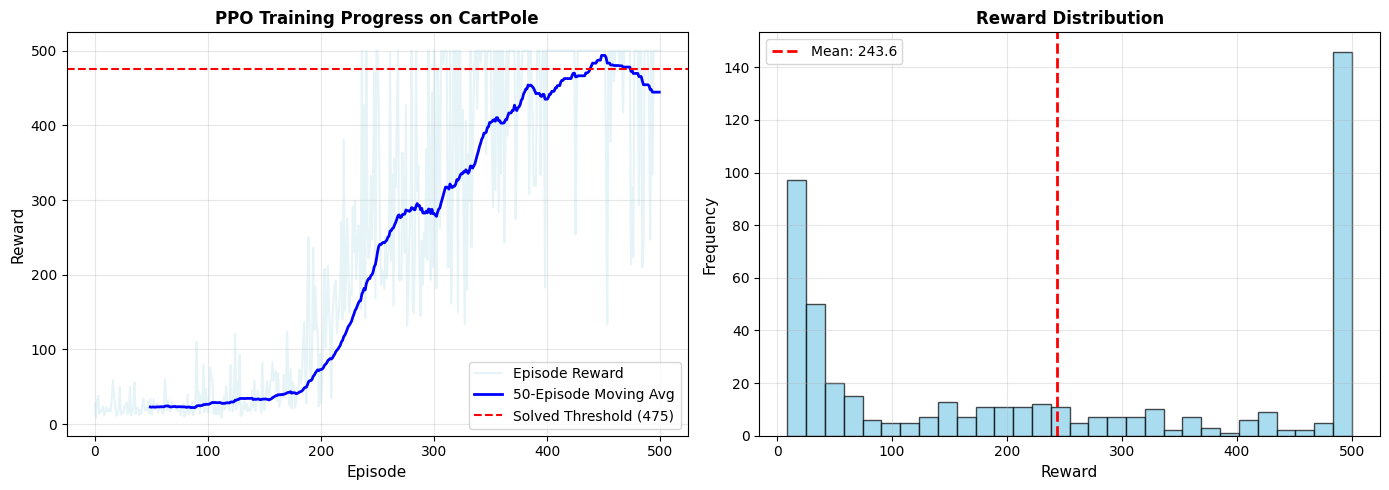

✓ Visualization saved


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Episode rewards
axes[0].plot(episode_rewards, alpha=0.3, color='lightblue', label='Episode Reward')
window = 50
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(episode_rewards)), moving_avg,
                 color='blue', linewidth=2, label=f'{window}-Episode Moving Avg')
axes[0].axhline(y=475, color='red', linestyle='--', label='Solved Threshold (475)')
axes[0].set_xlabel('Episode', fontsize=11)
axes[0].set_ylabel('Reward', fontsize=11)
axes[0].set_title('PPO Training Progress on CartPole', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Reward distribution
axes[1].hist(episode_rewards, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(np.mean(episode_rewards), color='red', linestyle='--',
                linewidth=2, label=f"Mean: {np.mean(episode_rewards):.1f}")
axes[1].set_xlabel('Reward', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Reward Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/mnt/user-data/outputs/', exist_ok=True)
plt.savefig('/mnt/user-data/outputs/ppo_cartpole_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

## Step 9: Test Trained Agent

In [ ]:
print("="*70)
print("Testing Trained Agent")
print("="*70)

test_env = gym.make('CartPole-v1')
agent.eval()

test_rewards = []
num_test_episodes = 10

for episode in range(num_test_episodes):
    state, _ = test_env.reset()
    episode_reward = 0

    for t in range(500):
        with torch.no_grad():
            action, _ = agent.act(state)

        state, reward, terminated, truncated, _ = test_env.step(action)
        episode_reward += reward

        if terminated or truncated:
            break

    test_rewards.append(episode_reward)
    print(f"Test Episode {episode + 1}: Reward = {episode_reward:.0f}")

test_env.close()

print(f"\n{'='*70}")
print(f"Average Test Reward: {np.mean(test_rewards):.1f} ± {np.std(test_rewards):.1f}")
print(f"Min: {min(test_rewards):.0f} | Max: {max(test_rewards):.0f}")
print(f"{'='*70}")

Testing Trained Agent
Test Episode 1: Reward = 500
Test Episode 2: Reward = 500
Test Episode 3: Reward = 500
Test Episode 4: Reward = 500
Test Episode 5: Reward = 500
Test Episode 6: Reward = 500
Test Episode 7: Reward = 500
Test Episode 8: Reward = 351
Test Episode 9: Reward = 500
Test Episode 10: Reward = 287

Average Test Reward: 463.8 ± 73.8
Min: 287 | Max: 500


## Summary

#### **PPO (This Notebook):**
- ✅ General reinforcement learning algorithm
- ✅ Agent learns to play CartPole game
- ✅ Reward: +1 for each timestep pole stays up
- ✅ Goal: Maximize total reward (keep pole balanced)
- ✅ Application: Games, robotics, control systems

#### **RLHF with PPO (Previous Notebook):**
- ✅ PPO applied to language models
- ✅ Agent learns to generate good text
- ✅ Reward: Quality score from reward model (human feedback)
- ✅ Goal: Generate human-preferred responses
- ✅ Application: ChatGPT, AI assistants

### Key Concepts:

**1. Policy (Actor):**
- Decides what action to take
- CartPole: Move left or right
- RLHF: Generate next word

**2. Value Function (Critic):**
- Estimates how good current state is
- Helps compute advantages for learning

**3. PPO Clipping:**
- Prevents too large policy updates
- Keeps training stable
- Clips ratio between 0.8 and 1.2 (with ε=0.2)

**4. Advantage:**
- How much better action was than expected
- Positive advantage → reinforce action
- Negative advantage → discourage action

### Why PPO is Popular:
- ✅ Stable training
- ✅ Sample efficient
- ✅ Works for many tasks
- ✅ Easy to implement
- ✅ Used in ChatGPT!

### Comparison Table:

| Feature | **PPO (CartPole)** | **RLHF with PPO (Language)** |
|---------|-------------------|------------------------------|
| **Environment** | CartPole game | Text generation |
| **State** | 4 numbers (cart pos, velocity, etc) | Prompt text |
| **Action** | 0 (left) or 1 (right) | Next word to generate |
| **Reward** | +1 per timestep | Quality score from reward model |
| **Episode** | Until pole falls | One text generation |
| **Goal** | Balance pole (500 steps) | Generate helpful response |
| **Algorithm** | PPO | PPO (same!) |

### The Big Picture:
PPO is a **universal learning algorithm**. Whether you're:
- Playing games (CartPole)
- Generating text (RLHF)
- Controlling robots
- Trading stocks

**The algorithm stays the same!** Only the:
- States (what you observe)
- Actions (what you can do)
- Rewards (what's good)

---
